<a href="https://colab.research.google.com/github/piziomo/Data-Science/blob/main/Feature%20Engineering/Feature%20Engineering_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Dimension Reduction

So far, we have worked with relatively small data sets, but often times, datasets may have a high number of dimensions. In those cases, appliying the methods we have covered in past sessions (i.e., visual exploration using data visualisations, correlations between two variables...) may be really difficult, if not impossible to do.

In this notebook we are going to explore two different techniques for reducing the dimensionality of our data: Clustering and Principle Component Analysis (PCA).

## Data preparations

In this notebook, we are going to use the simple [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) [@r_a_fisher_iris_1936]. The dataset, which is famously used to introduce these methods, consists of 4 measures or attributes (the length and the width of the sepals and petals, in centimeters) describing 50 samples from three species of flowers (_Iris setosa_, _Iris virginica_ and _Iris versicolor_).

::: aside
![ Image of a primrose willowherb ''Ludwigia octovalvis'' (Family Onagraceae), flower showing petals and sepals. Photograph made in Hawai'i by Eric Guinther and released under the GNU Free Documentation License.](media/451px-Petal-sepal.jpg)

:::

Contrary to previous sessions, in this case, the dataset will not be read from a `csv` file, but it is provided by the `sklearn.datasets` submodule:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()

# Explore our data.
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

Regretfully, the iris dataset is not a data frame as the previous ones:

In [ ]:
type(iris)

sklearn.utils._bunch.Bunch

This means that, if we want to apply all the methods that we are familiar with, we will need to convert this odd data type into a pandas dataframe format we know and love. We can do this following [this stackoverflow answer](https://stackoverflow.com/questions/38105539/how-to-convert-a-scikit-learn-dataset-to-a-pandas-dataset):

In [ ]:
import pandas as pd

iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


As usual, we may want to see some descriptive measures to get a sense of the data:

In [ ]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



::: {.callout-warning collapse="true"}

### What is this telling us?

As can be seen from above, we do not have any missing data (all variables have 150 observations) but the scale (ranges) for every variable differ considerably (look the min and max values of sepal length and compare them with petal width).
:::

### Normalisation

Some algorithms are senstive to the size of variables. For example, if the sepal widths were in meters and the other variables in cm then an algorithm may underweight sepal widths. This means that we will need to rescale our variables to be in the safe side. There are two ways to put variables into the same scale: normalisation and standarisation.

- **Normalisation:** rescales a dataset so that each **value** falls between 0 and 1. It uses the following formula to do so:

$$xnew = (xi – xmin) / (xmax – xmin)$$

- **Standarisation:** rescales a dataset to have a **mean** of 0 and a **standard deviation** of 1. It uses the following formula to do so:

$$xnew = (xi – x) / s$$

::: callout-caution

### Which one should we use?

If you cannot choose between them then try it both ways. You could compare the result with your raw data, the normalised data and the standardised data.

These blog posts may help you: [(Statology) Standardization vs. Normalization: What’s the Difference?](https://www.statology.org/standardization-vs-normalization/) and [(Analytics Vidhya) Feature Engineering: Scaling, Normalization, and Standardization (Updated 2023)](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)).

:::


In the code below we will normalise the data between `0` and `1`  by using `.fit_transform()` from sklearn.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
col_names = iris_df.columns
iris_df =  pd.DataFrame(MinMaxScaler().fit_transform(iris_df))
iris_df.columns = col_names # Column names were lost, so we need to re-introduce
iris_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


Let's see how the the descriptive measures have changed after the transformation:

In [ ]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.440556,0.467458,0.458056
std,0.230018,0.181611,0.299203,0.317599
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


Great.

Our dataset show us the length and width of both the sepal (leaf) and petals of 150 plants. The dataset is quite famous and you can find a [wikipedia page](https://en.wikipedia.org/wiki/Iris_flower_data_set) with details of the dataset.

::: callout-caution

### Questions

To motivate our exploration of the data, consider the sorts of questions we can ask:

* Are all our plants from the same species?
* Do some plants have similiar leaf and petal sizes?
* Can we differentiate between the plants using all 4 variables (dimensions)?
* Do we need to include both length and width, or can we reduce these dimensions and simplify our analysis?

:::

### Initial exploration

We can explore a dataset with few variables using plots.


#### Distribution (variabilty and density)

We'd like to see each variable's distributions in terms of variablity and density. We have seen several ways to do this, but in this case we will be using a new plot type (a [violin plot](https://en.wikipedia.org/wiki/Violin_plot)) to visualise the distribution.

To do so, we will be using seaborn's [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Because we want to create a single plot with a violin plot per variable, we will need to transform our data from wide to a long format.

::: aside

![Explanation of Violin plot. ([Chambers 2017](http://dx.doi.org/10.13140/RG.2.2.26587.62244))](media/Explanation-of-Violin-plot-Densities-are-estimated-using-a-Gaussian-kernel-density.png)

:::


::: {.callout-tip collapsed=false}

### Wide vs long data

A dataset can be written in two different formats: wide and long.

- **wide**: every row is a unique observation, where columns are variables (or attributes) describing the observation.
- **long**: single observations are split into multiple rows. Usually, the first column contains the index to the observation, and there are two more columns: the name of the variable, and the actual value of the variable.

![Wide vs long data (Source: [Statology](https://www.statology.org/long-vs-wide-data/))](media/wideLong1-1-768x543.png)

:::


In [ ]:
import seaborn as sns

# some plots require a long dataframe structure
iris_df_long = iris_df.melt()
iris_df_long

,variable,value
0,sepal length (cm),0.222222
1,sepal length (cm),0.166667
2,sepal length (cm),0.111111
3,sepal length (cm),0.083333
4,sepal length (cm),0.194444
...,...,...
595,petal width (cm),0.916667
596,petal width (cm),0.750000
597,petal width (cm),0.791667
598,petal width (cm),0.916667


And now that we have transformed our data into a long data format, we can create the visualisation:

<Axes: xlabel='variable', ylabel='value'>

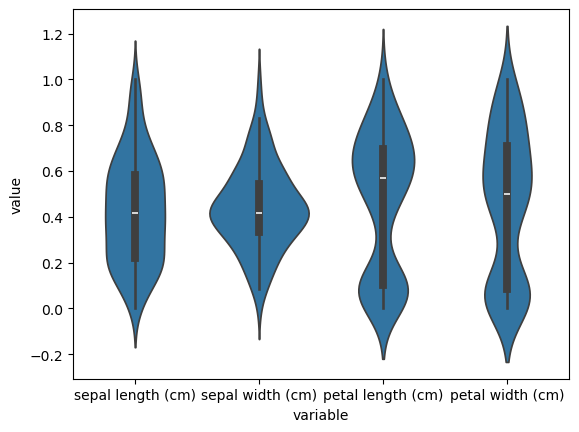

In [ ]:
sns.violinplot(data = iris_df_long, x = 'variable', y = 'value')

#### Correlations

The below plots use the wide data structure.

In [ ]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

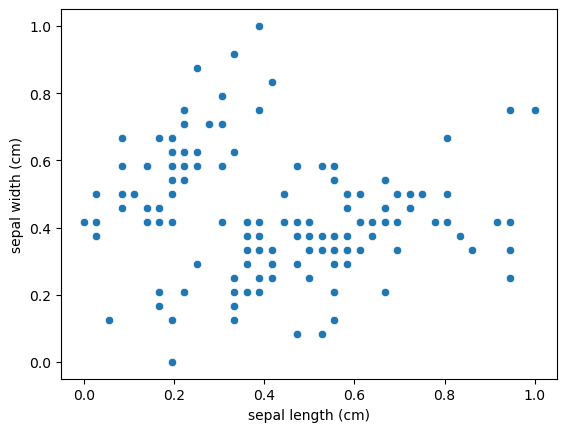

In [ ]:
sns.scatterplot(data = iris_df, x = 'sepal length (cm)', y = 'sepal width (cm)')

<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>

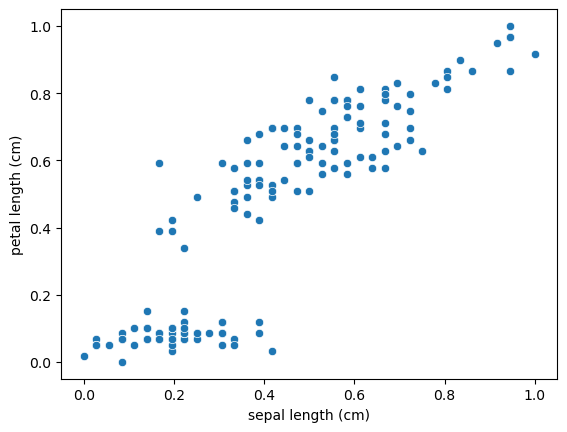

In [ ]:
sns.scatterplot(data = iris_df, x = 'sepal length (cm)', y = 'petal length (cm)')

Interesting. There seem to be two groupings in the data.

It might be easier to look at all the variables at once.

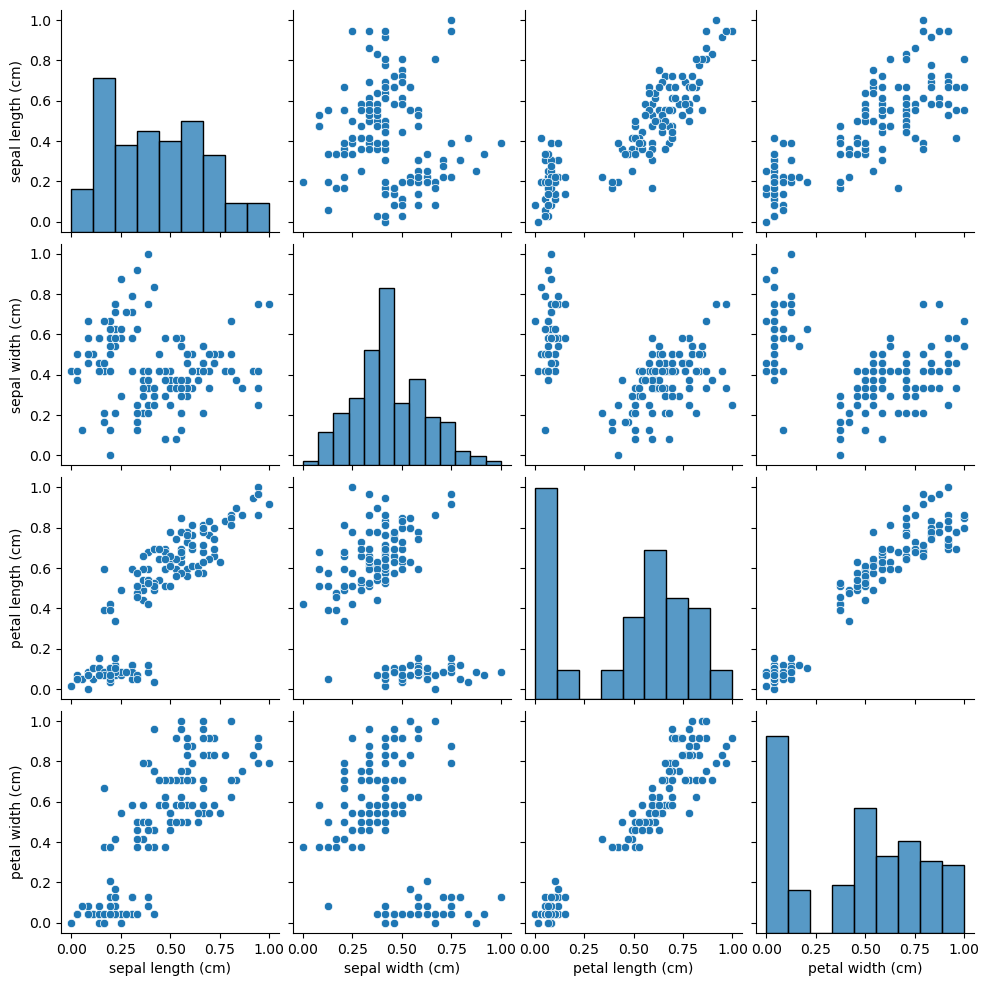

In [ ]:
#| column: page-right

sns.pairplot(iris_df)

There seem to be some groupings in the data. Though we cannot easily identify which point corresponds to which row.

## Clustering

A cluster is simply a group based on simliarity. There are several methods and we will use a relatively simple one called K-means clustering.

In K-means clustering an algorithm tries to group our items (plants in the iris dataset) based on similarity. We decide how many groups we want and the algorithm does the best it can (an accessible introduction to k-means clustering is [here](https://www.analyticsvidhya.com/blog/2020/10/a-simple-explanation-of-k-means-clustering/)).

To start, we import the KMeans function from sklearn cluster module and turn our data into a matrix.

In [ ]:
from sklearn.cluster import KMeans

iris = iris_df.values
iris

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

### Specify our number of clusters.

::: callout-caution

## IMPORTANT: Check if your data features are standardised/normalised!!

Before you apply techniques such as PCA, clustering or other feature embedding technniques (such as t-SNE, MDS, etc.). It is very important to make sure that the data features that go into these techniques are normalised/standardised:
- you can bring the value ranges between 0 and 1 for all of them with a MixMax scaling operation - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- you can standardise the values to have a mean of 0 and a standard deviation of 1, aka, z-score standardisation -- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- Or make use of more specific normalisation operators that might be more suitable for a particular context. The scikit-learn collection is a good place to look for alternatives -- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

These operations ensure that the results are not biased/skewed/dominated by some of the inherent characteristics of the data that is simply due to the *domain* of values.

Scikit-learn has some very nice tutorial here: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

:::

::: callout-caution

## Do-this-yourself: Check if we need to do any normalisation for this case?

We have already looked at how the data looks, what are the descriptive statistics look like, see if we need to do anything more?

:::

In [ ]:
k_means = KMeans(n_clusters = 4, init = 'random',  n_init = 10)

Fit our kmeans model to the data

In [ ]:
k_means.fit(iris)

KMeans(init='random', n_clusters=4, n_init=10)

The algorithm has assigned the a label to each row.

In [ ]:
k_means.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 3, 0, 3, 0, 3, 0, 0, 3, 0, 3, 0, 3,
       3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 3, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1, 3, 1, 3, 1, 1, 0, 1, 3, 1,
       1, 3, 1, 3, 3, 1, 3, 1, 1, 0, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1,
       1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3], dtype=int32)

Each row has been assigned a label.

To tidy things up we should put everything into a dataframe.

In [ ]:
# Select only the original 4 features (assuming the columns are named as such)
iris_df['Four clusters'] = pd.Series(k_means.predict(iris_df.iloc[:, :4].values), index=iris_df.index)


In [ ]:
# iris_df['Four clusters'] = pd.Series(k_means.predict(iris_df.values), index = iris_df.index)

In [ ]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Three clusters,Four clusters
0,0.222222,0.625000,0.067797,0.041667,1,2
1,0.166667,0.416667,0.067797,0.041667,1,2
2,0.111111,0.500000,0.050847,0.041667,1,2
3,0.083333,0.458333,0.084746,0.041667,1,2
4,0.194444,0.666667,0.067797,0.041667,1,2
...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0,1
146,0.555556,0.208333,0.677966,0.750000,2,3
147,0.611111,0.416667,0.711864,0.791667,0,3
148,0.527778,0.583333,0.745763,0.916667,0,1


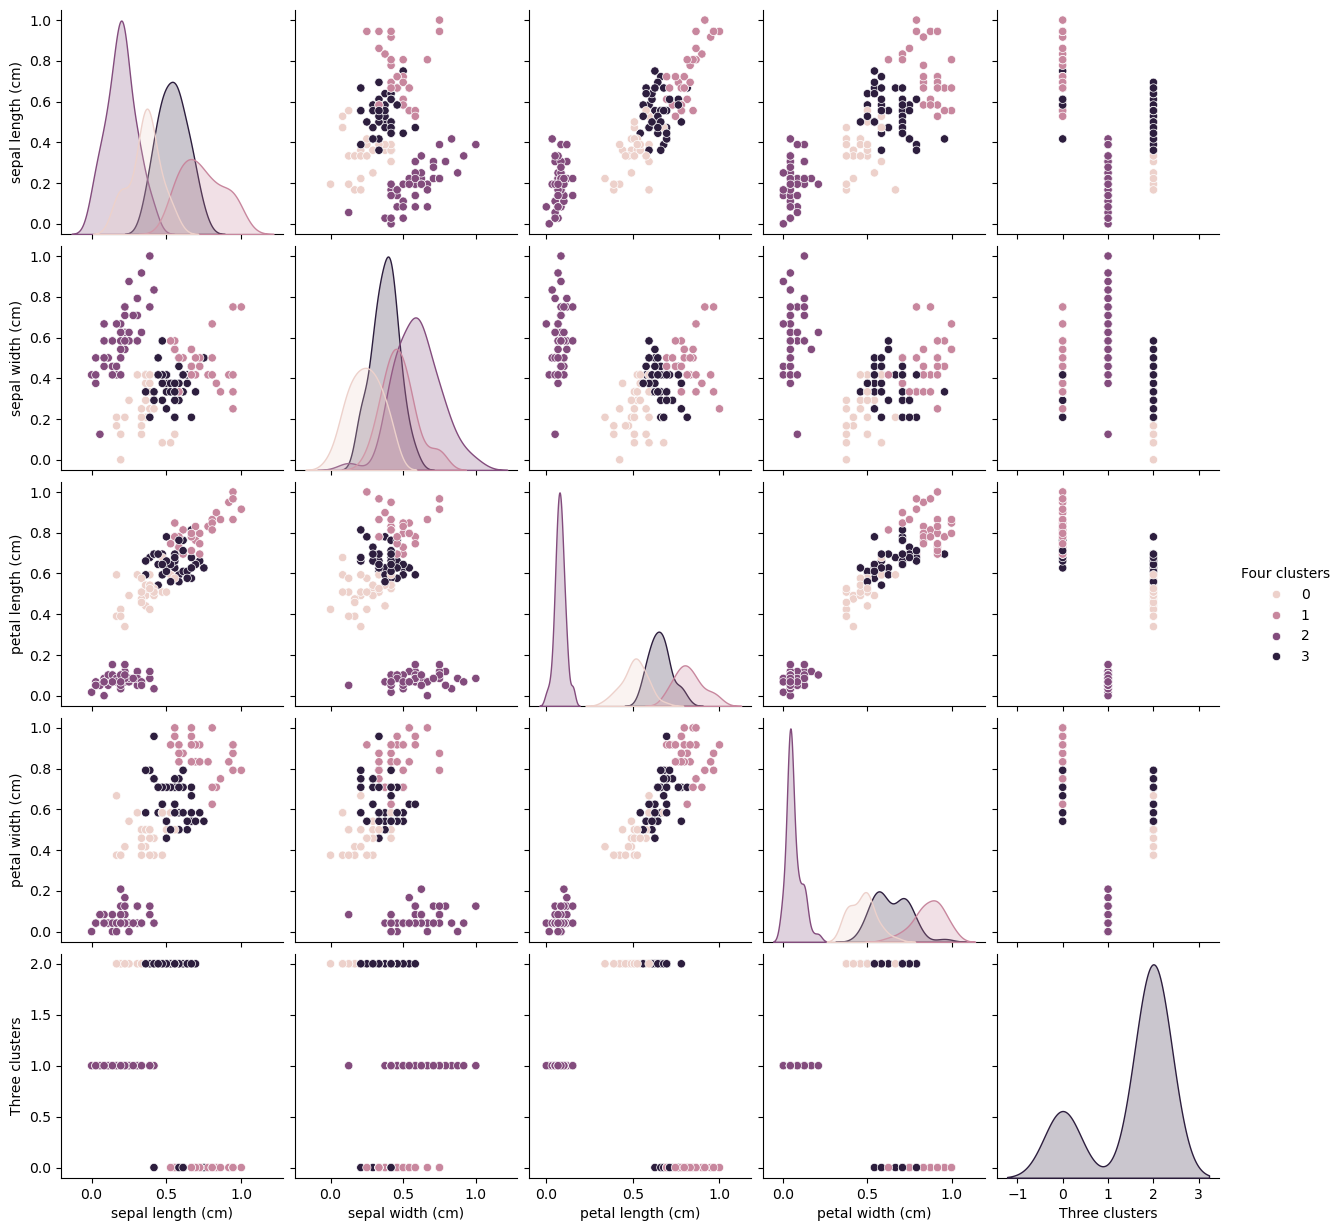

In [ ]:
#| column: page-right

sns.pairplot(iris_df, hue = 'Four clusters')

That seems quite nice. We can also do individual plots if preferred.

<Axes: xlabel='sepal length (cm)', ylabel='petal width (cm)'>

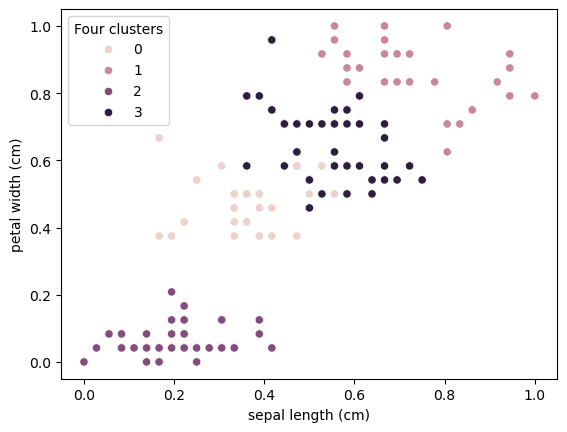

In [ ]:
sns.scatterplot(data = iris_df, x = 'sepal length (cm)', y = 'petal width (cm)', hue = 'Four clusters')

K-means works by clustering the data around central points (often called centroids, means or cluster centers). We can extract the cluster centres from the kmeans object.

In [ ]:
k_means.cluster_centers_

array([[0.35632184, 0.23706897, 0.50905903, 0.47126437],
       [0.73850575, 0.47270115, 0.82291058, 0.86350575],
       [0.19611111, 0.595     , 0.07830508, 0.06083333],
       [0.54166667, 0.375     , 0.65657789, 0.64186508]])

It is tricky to plot these using seaborn but we can use a normal maplotlib scatter plot.

Let us grab the groups.

In [ ]:
group1 = iris_df[iris_df['Three clusters'] == 0]
group2 = iris_df[iris_df['Three clusters'] == 1]
group3 = iris_df[iris_df['Three clusters'] == 2]
group3 = iris_df[iris_df['Three clusters'] == 3]

Grab the centroids

In [ ]:
import pandas as pd

centres = k_means.cluster_centers_

data = {'x': [centres[0][0], centres[1][0], centres[2][0]],
        'y': [centres[0][3], centres[1][3], centres[2][3]]}

df = pd.DataFrame (data, columns = ['x', 'y'])

Create the plot

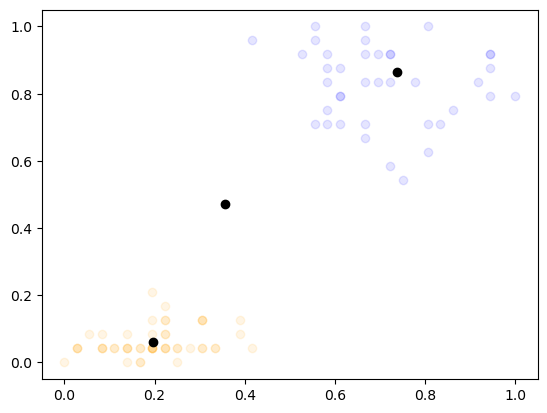

In [ ]:
import matplotlib.pyplot as plt

# Plot each group individually
plt.scatter(
    x = group1['sepal length (cm)'],
    y = group1['petal width (cm)'],
    alpha = 0.1, color = 'blue'
)

plt.scatter(
    x = group2['sepal length (cm)'],
    y = group2['petal width (cm)'],
    alpha = 0.1, color = 'orange'
)

plt.scatter(
    x = group3['sepal length (cm)'],
    y = group3['petal width (cm)'],
    alpha = 0.1, color = 'red'
)

# Plot cluster centres
plt.scatter(
    x = df['x'],
    y = df['y'],
    alpha = 1, color = 'black'
)


### Changing the number of clusters

What happens if we change the number of clusters?

Two groups

In [ ]:
k_means_2 = KMeans(n_clusters = 2, init = 'random', n_init = 10)
k_means_2.fit(iris)
iris_df['Two clusters'] = pd.Series(k_means_2.predict(iris_df.iloc[:,0:4].values), index = iris_df.index)

Note that I have added a new column to the iris dataframe called 'cluster 2 means' and pass only our origonal 4 columns to the predict function (hence me using .iloc[:,0:4]).

How do our groupings look now (without plotting the cluster column)?

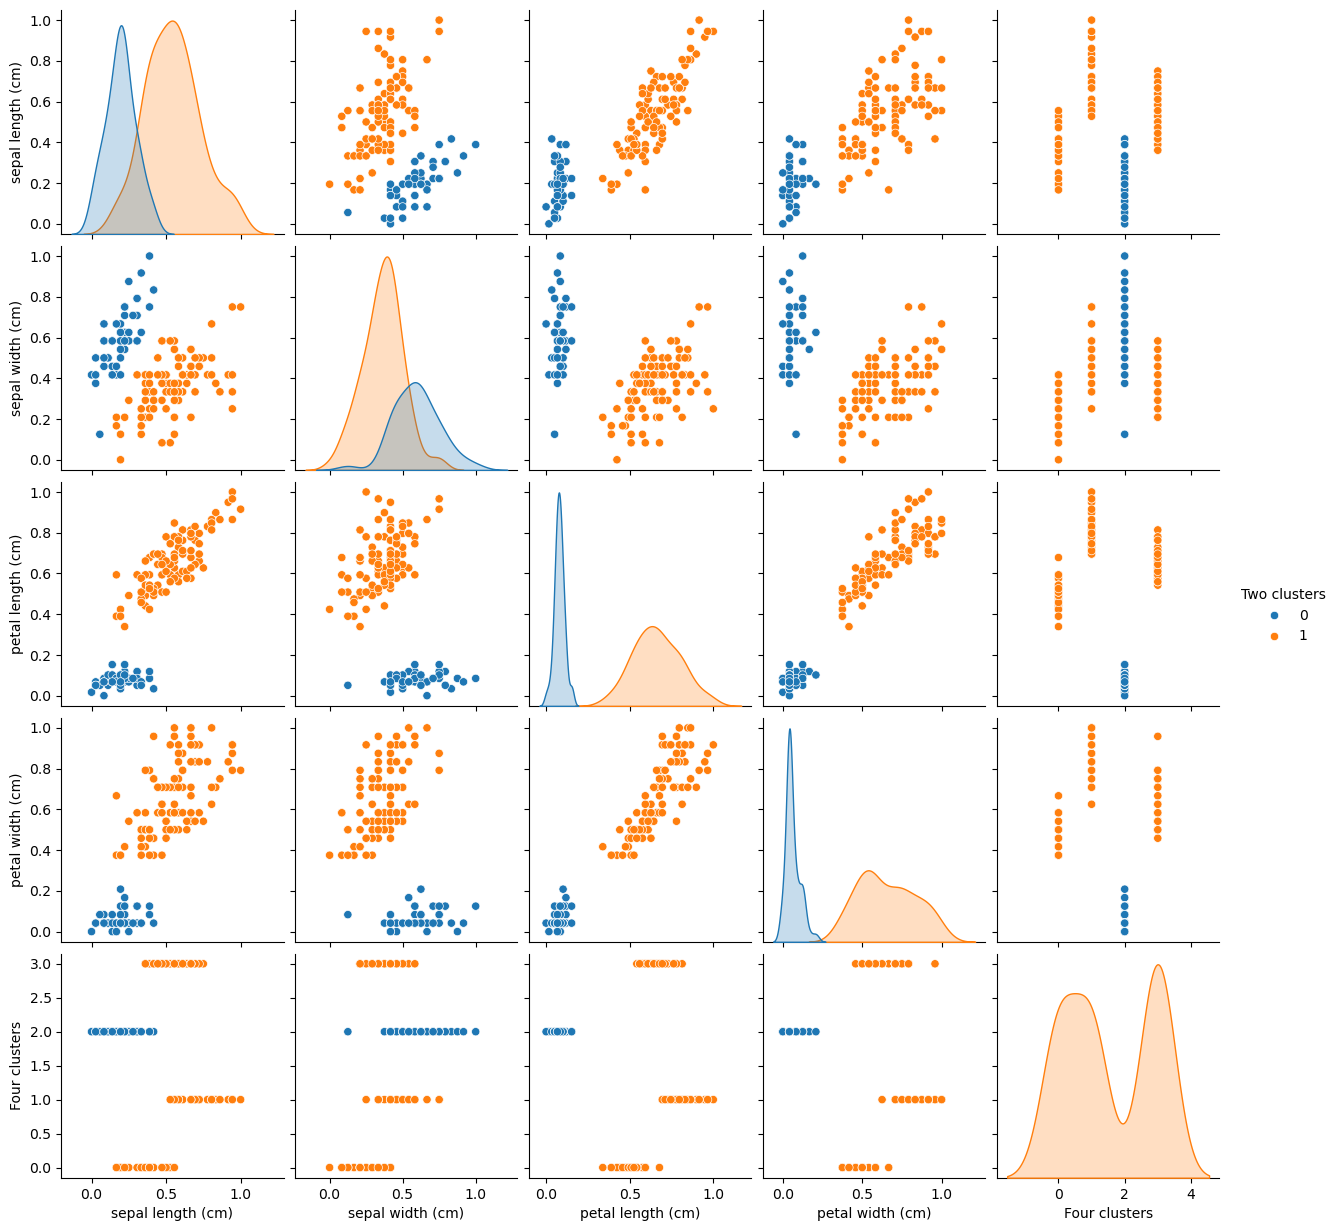

In [ ]:
#| column: page-right

sns.pairplot(iris_df.loc[:, iris_df.columns != 'Three clusters'], hue = 'Two clusters')

Hmm, does the data have more than two groups in it?

Perhaps we should try 5 clusters instead.

In [ ]:
k_means_5 = KMeans(n_clusters = 5, init = 'random', n_init = 10)
k_means_5.fit(iris)
iris_df['Five clusters'] = pd.Series(k_means_5.predict(iris_df.iloc[:,0:4].values), index = iris_df.index)

Plot without the columns called 'cluster' and 'Two cluster'

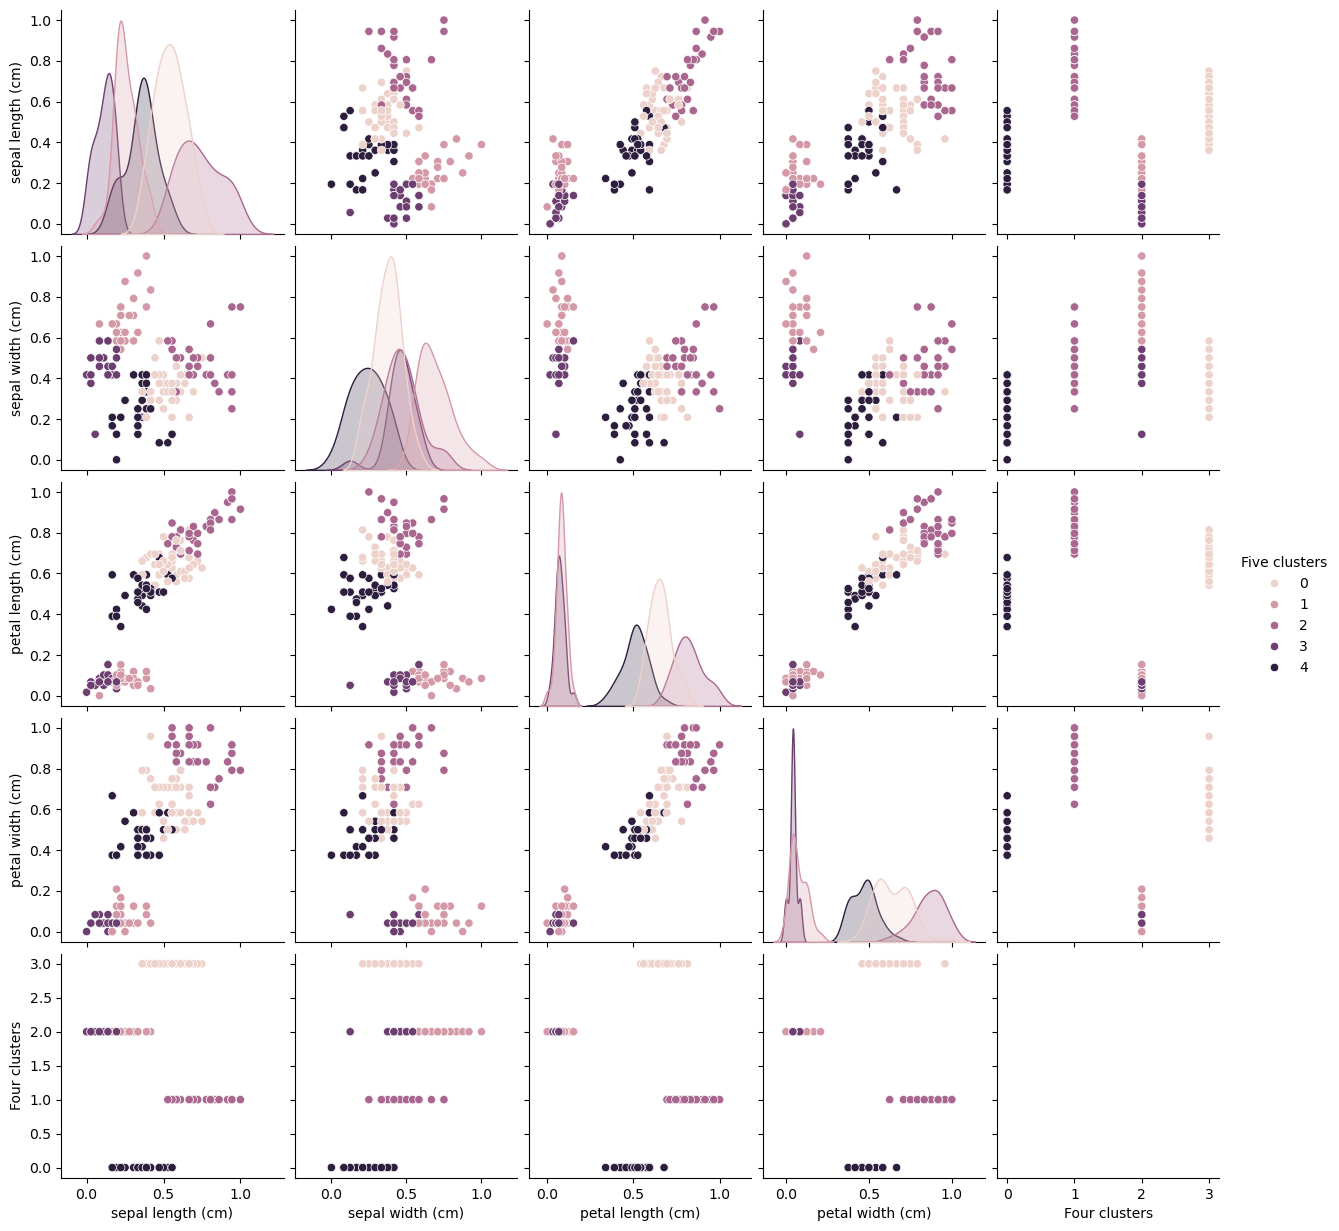

In [ ]:
#| column: page-right

sns.pairplot(iris_df.loc[:, (iris_df.columns != 'Three clusters') & (iris_df.columns != 'Two clusters')], hue = 'Five clusters')

In [ ]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Three clusters,Four clusters,Two clusters,Five clusters
0,0.222222,0.625000,0.067797,0.041667,1,2,0,1
1,0.166667,0.416667,0.067797,0.041667,1,2,0,3
2,0.111111,0.500000,0.050847,0.041667,1,2,0,3
3,0.083333,0.458333,0.084746,0.041667,1,2,0,3
4,0.194444,0.666667,0.067797,0.041667,1,2,0,1
...,...,...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0,1,1,2
146,0.555556,0.208333,0.677966,0.750000,2,3,1,0
147,0.611111,0.416667,0.711864,0.791667,0,3,1,0
148,0.527778,0.583333,0.745763,0.916667,0,1,1,2


Which did best?

In [ ]:
k_means.inertia_

5.51693347204037

In [ ]:
k_means_2.inertia_

12.127790750538196

In [ ]:
k_means_5.inertia_

4.580948640117294

It looks like our k = 5 model captures the data well. Intertia, [looking at the sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) as the _Sum of squared distances of samples to their closest cluster center._.

If you want to dive further into this then Real Python's [practical guide to K-Means Clustering](https://realpython.com/k-means-clustering-python/) is quite good.

## Principal Component Analysis (PCA)



PCA reduces the dimension of our data. The method derives point in an n dimentional space from our data which are uncorrelated.

To carry out a PCA on our Iris dataset where there are only two dimensions.

In [ ]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)
iris_pca = pca.fit(iris_df.iloc[:,0:4])

We can look at the components.

In [ ]:
iris_pca.components_

array([[ 0.42494212, -0.15074824,  0.61626702,  0.64568888],
       [ 0.42320271,  0.90396711, -0.06038308, -0.00983925]])

These components are intersting. You may want to look at a [PennState article on interpreting PCA components](https://online.stat.psu.edu/stat505/lesson/11/11.4).

Our second column, 'sepal width (cm)' is positively correlated with our second principle component whereas the first column 'sepal length (cm)' is postively correlated with both.

You may want to consider:

* Do we need more than two components?
* Is it useful to keep sepal length (cm) in the dataset?

We can also examine the explained variance of the each principle component.

In [ ]:
iris_pca.explained_variance_

array([0.23245325, 0.0324682 ])

A nice worked example showing the link between the explained variance and the component is [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

Our first principle component explains a lot more of the variance of data then the second.

Another way to explore these indicators is to look at the `explained_variance_ratio_` values. These present a similar information but provide them as percentage values so they are easier to interpret. You can also create a plot and see how these percentages add up. In this case, the first two components add up to 0.96. Which means the first two features are able to represent around 96% of the variation in the data, not bad. These values are not always this high.

A high value that is close to 100% means that the PCA is able to represent much of the variance and they will be good representations of the data without losing a lot of that variance in the underlying features. This of course is based on an assumption that `variance` is a good proxy about how informative a feature is.

In [ ]:
iris_pca.explained_variance_ratio_

array([0.84136038, 0.11751808])

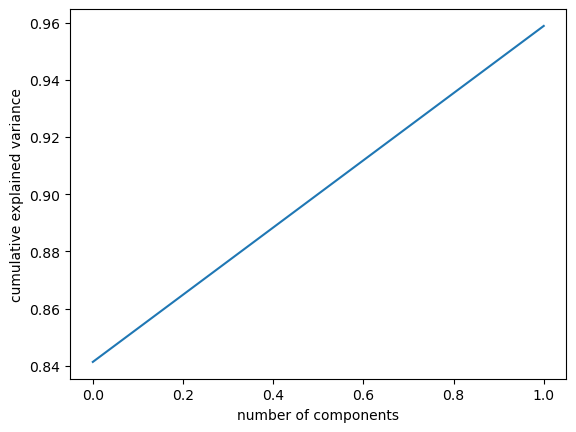

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Dimension reduction

For our purposes, we are interested in using PCA for reducing the number of dimension in our data whilst preseving the maximal data variance.

We can extract the projected components from the model.

In [ ]:
iris_pca_vals = pca.fit_transform(iris_df.iloc[:,0:4])

The numpy arrays contains the projected values.

In [ ]:
type(iris_pca_vals)

numpy.ndarray

In [ ]:
iris_pca_vals

array([[-6.30702931e-01,  1.07577910e-01],
       [-6.22904943e-01, -1.04259833e-01],
       [-6.69520395e-01, -5.14170597e-02],
       [-6.54152759e-01, -1.02884871e-01],
       [-6.48788056e-01,  1.33487576e-01],
       [-5.35272778e-01,  2.89615724e-01],
       [-6.56537790e-01,  1.07244911e-02],
       [-6.25780499e-01,  5.71335411e-02],
       [-6.75643504e-01, -2.00703283e-01],
       [-6.45644619e-01, -6.72080097e-02],
       [-5.97408238e-01,  2.17151953e-01],
       [-6.38943190e-01,  3.25988375e-02],
       [-6.61612593e-01, -1.15605495e-01],
       [-7.51967943e-01, -1.71313322e-01],
       [-6.00371589e-01,  3.80240692e-01],
       [-5.52157227e-01,  5.15255982e-01],
       [-5.77053593e-01,  2.93709492e-01],
       [-6.03799228e-01,  1.07167941e-01],
       [-5.20483461e-01,  2.87627289e-01],
       [-6.12197555e-01,  2.19140388e-01],
       [-5.57674300e-01,  1.02109180e-01],
       [-5.79012675e-01,  1.81065123e-01],
       [-7.37784662e-01,  9.05588211e-02],
       [-5.

Each row corresponds to a row in our data.

In [ ]:
iris_pca_vals.shape

(150, 2)

In [ ]:
iris_df.shape

(150, 11)

We can add the component to our dataset. I prefer to keep everything in one table and it is not at all required. You can just assign the values whichever variables you prefer.

In [ ]:
iris_df['c1'] = [item[0] for item in iris_pca_vals]
iris_df['c2'] = [item[1] for item in iris_pca_vals]

In [ ]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Three clusters,Four clusters,Two clusters,Five clusters,c1,c2,PCA 3 clusters
0,0.222222,0.625000,0.067797,0.041667,1,2,0,1,-0.630703,0.107578,1
1,0.166667,0.416667,0.067797,0.041667,1,2,0,3,-0.622905,-0.104260,1
2,0.111111,0.500000,0.050847,0.041667,1,2,0,3,-0.669520,-0.051417,1
3,0.083333,0.458333,0.084746,0.041667,1,2,0,3,-0.654153,-0.102885,1
4,0.194444,0.666667,0.067797,0.041667,1,2,0,1,-0.648788,0.133488,1
...,...,...,...,...,...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0,1,1,2,0.551462,0.059841,2
146,0.555556,0.208333,0.677966,0.750000,2,3,1,0,0.407146,-0.171821,0
147,0.611111,0.416667,0.711864,0.791667,0,3,1,0,0.447143,0.037560,2
148,0.527778,0.583333,0.745763,0.916667,0,1,1,2,0.488208,0.149678,2


Plotting out our data on our new two component space.

<Axes: xlabel='c1', ylabel='c2'>

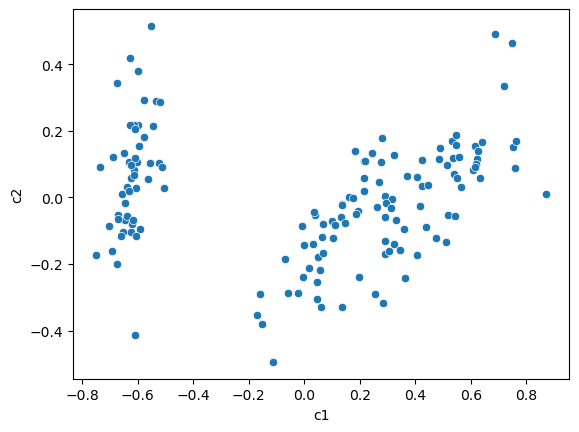

In [ ]:
sns.scatterplot(data = iris_df, x = 'c1', y = 'c2')

We have reduced our three dimensions to two.

We can also colour by our clusters. What does this show us and is it useful?

<Axes: xlabel='c1', ylabel='c2'>

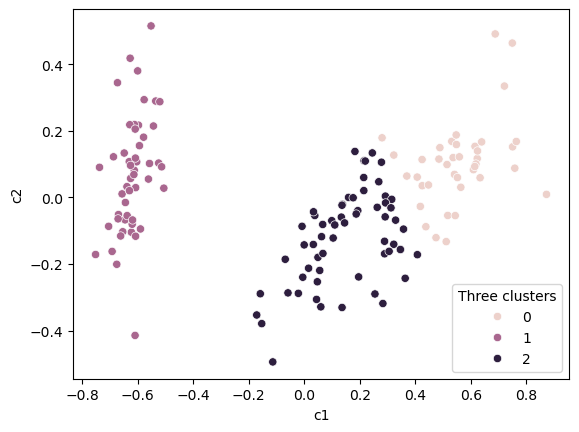

In [ ]:
sns.scatterplot(data = iris_df, x = 'c1', y = 'c2', hue = 'Three clusters')

In [ ]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Three clusters,Four clusters,Two clusters,Five clusters,c1,c2,PCA 3 clusters
0,0.222222,0.625000,0.067797,0.041667,1,2,0,1,-0.630703,0.107578,1
1,0.166667,0.416667,0.067797,0.041667,1,2,0,3,-0.622905,-0.104260,1
2,0.111111,0.500000,0.050847,0.041667,1,2,0,3,-0.669520,-0.051417,1
3,0.083333,0.458333,0.084746,0.041667,1,2,0,3,-0.654153,-0.102885,1
4,0.194444,0.666667,0.067797,0.041667,1,2,0,1,-0.648788,0.133488,1
...,...,...,...,...,...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0,1,1,2,0.551462,0.059841,2
146,0.555556,0.208333,0.677966,0.750000,2,3,1,0,0.407146,-0.171821,0
147,0.611111,0.416667,0.711864,0.791667,0,3,1,0,0.447143,0.037560,2
148,0.527778,0.583333,0.745763,0.916667,0,1,1,2,0.488208,0.149678,2


### PCA to Clusters

We have reduced our 4D dataset to 2D whilst keeping the data variance. Reducing the data to fewer dimensions can help with the 'curse of dimensionality', reduce the change of overfitting a machine learning model (see [here](https://en.wikipedia.org/wiki/Dimensionality_reduction)) and reduce the computational complexity of a model fit.

Putting our new dimensions into a kMeans model

In [ ]:
k_means_pca = KMeans(n_clusters = 3, init = 'random', n_init = 10)
iris_pca_kmeans = k_means_pca.fit(iris_df.iloc[:,-2:])

In [ ]:
type(iris_df.iloc[:,-2:].values)

numpy.ndarray

In [ ]:
iris_df['PCA 3 clusters'] = pd.Series(k_means_pca.predict(iris_df.iloc[:,-2:].values), index = iris_df.index)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Three clusters,Four clusters,Two clusters,Five clusters,c1,c2,PCA 3 clusters
0,0.222222,0.625000,0.067797,0.041667,1,2,0,1,-0.630703,0.107578,1
1,0.166667,0.416667,0.067797,0.041667,1,2,0,3,-0.622905,-0.104260,1
2,0.111111,0.500000,0.050847,0.041667,1,2,0,3,-0.669520,-0.051417,1
3,0.083333,0.458333,0.084746,0.041667,1,2,0,3,-0.654153,-0.102885,1
4,0.194444,0.666667,0.067797,0.041667,1,2,0,1,-0.648788,0.133488,1
...,...,...,...,...,...,...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,0,1,1,2,0.551462,0.059841,0
146,0.555556,0.208333,0.677966,0.750000,2,3,1,0,0.407146,-0.171821,2
147,0.611111,0.416667,0.711864,0.791667,0,3,1,0,0.447143,0.037560,0
148,0.527778,0.583333,0.745763,0.916667,0,1,1,2,0.488208,0.149678,0


As we only have two dimensions we can easily plot this on a single scatterplot.

<Axes: xlabel='c1', ylabel='c2'>

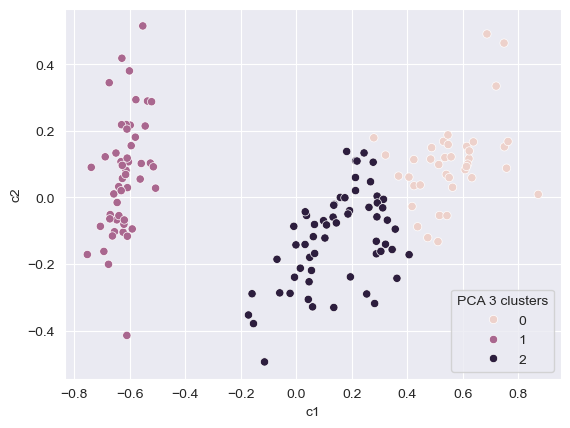

In [ ]:
# a different seaborn theme
# see https://python-graph-gallery.com/104-seaborn-themes/
sns.set_style("darkgrid")
sns.scatterplot(data = iris_df, x = 'c1', y = 'c2', hue = 'PCA 3 clusters')

I suspect having two clusters would work better. We should try a few different models.

Copying the code from [here](https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2) we can fit multiple numbers of clusters.

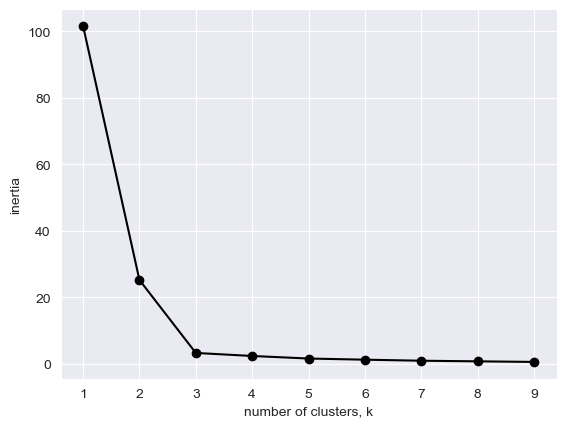

In [ ]:
ks = range(1, 10)
inertias = [] # Create an empty list (will be populated later)
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init = 10)

    # Fit model to samples
    model.fit(iris_df.iloc[:,-2:])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Three seems ok. We clearly want no more than three.

These types of plots show an point about model complexity. More free parameters in the model (here the number of clusters) will improve how well the model captures the data, often with reducing returns. However, a model which overfits the data will not be able to fit new data well - referred to overfitting. Randomish internet blogs introduce the topic pretty well, see [here](https://elitedatascience.com/overfitting-in-machine-learning), and also wikipedia, see [here](https://en.wikipedia.org/wiki/Overfitting).



### Missing values

Finally, how we deal with missing values can impact the results of PCA and kMeans clustering.

Lets us load in the iris dataset again and randomly remove 10% of the data (see code from [here](https://stackoverflow.com/questions/42091018/randomly-insert-nas-values-in-a-pandas-dataframe-with-no-rows-completely-miss)).

In [ ]:
import numpy as np

x = load_iris()

In [ ]:
iris_df = pd.DataFrame(x.data, columns = x.feature_names)

mask = np.random.choice([True, False], size = iris_df.shape, p = [0.2, 0.8])
mask[mask.all(1),-1] = 0

df = iris_df.mask(mask)

df.isna().sum()

sepal length (cm)    30
sepal width (cm)     27
petal length (cm)    32
petal width (cm)     41
dtype: int64

In [ ]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,NaN,NaN,1.3,0.2
3,4.6,NaN,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,NaN,5.0,1.9
147,6.5,NaN,5.2,2.0
148,6.2,NaN,NaN,2.3


About 20% of the data is randomly an NaN.

#### Zeroing

We can 0 them and fit our models.

In [ ]:
df_1 = df.copy()
df_1 = df_1.fillna(0)

In [ ]:
df_1

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,0.0,0.0,1.3,0.2
3,4.6,0.0,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,0.0,5.0,1.9
147,6.5,0.0,5.2,2.0
148,6.2,0.0,0.0,2.3


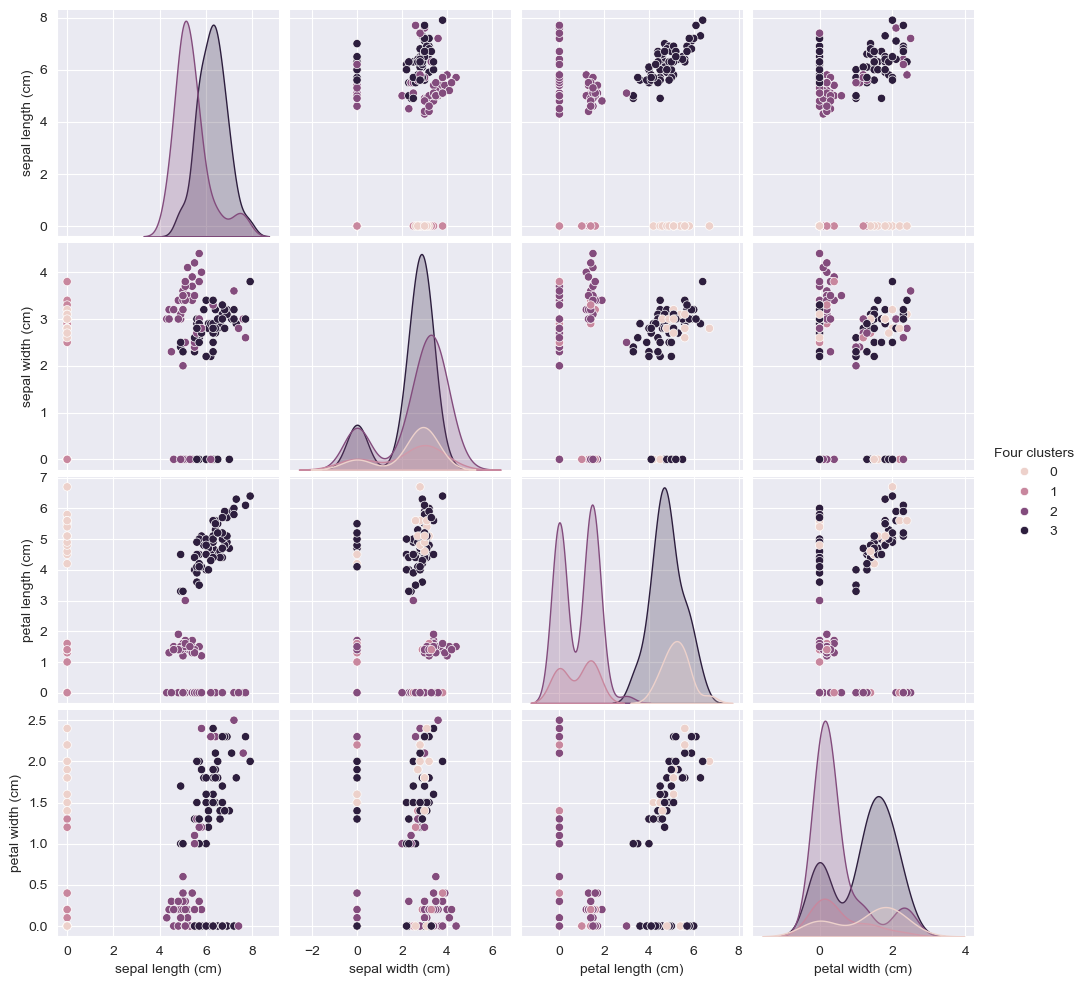

In [ ]:
#| column: page-right

k_means_zero = KMeans(n_clusters = 4, init = 'random', n_init = 10)
k_means_zero.fit(df_1)
df_1['Four clusters'] = pd.Series(k_means_zero.predict(df_1.iloc[:,0:4].values), index = df_1.index)
sns.pairplot(df_1, hue = 'Four clusters')

What impact has zeroing the values had on our results?

Now, onto PCA.

<Axes: xlabel='c1', ylabel='c2'>

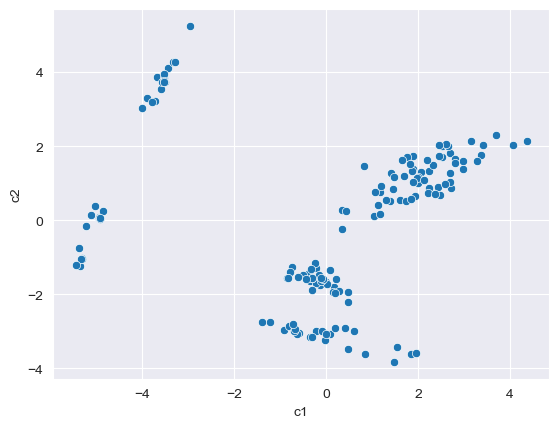

In [ ]:
# PCA analysis
n_components = 2

pca = PCA(n_components=n_components)
df_1_pca = pca.fit(df_1.iloc[:,0:4])

# Extract projected values
df_1_pca_vals = df_1_pca.transform(df_1.iloc[:,0:4])
df_1['c1'] = [item[0] for item in df_1_pca_vals]
df_1['c2'] = [item[1] for item in df_1_pca_vals]

sns.scatterplot(data = df_1, x = 'c1', y = 'c2')

In [ ]:
df_1_pca.explained_variance_

array([6.23976224, 4.64071279])

In [ ]:
df_1_pca.components_

array([[ 0.93421216,  0.04984247,  0.3429415 ,  0.08458428],
       [-0.34939266, -0.05582439,  0.92376983,  0.14648449]])

#### Replacing with the average

In [ ]:
df_2 = df.copy()
for i in range(4):
    df_2.iloc[:,i] = df_2.iloc[:,i].fillna(df_2.iloc[:,i].mean())

In [ ]:
df_2

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.100000,3.500000,1.40000,0.2
1,4.900000,3.000000,1.40000,0.2
2,5.836667,3.023577,1.30000,0.2
3,4.600000,3.023577,1.50000,0.2
4,5.000000,3.600000,1.40000,0.2
...,...,...,...,...
145,6.700000,3.000000,5.20000,2.3
146,6.300000,3.023577,5.00000,1.9
147,6.500000,3.023577,5.20000,2.0
148,6.200000,3.023577,3.74661,2.3


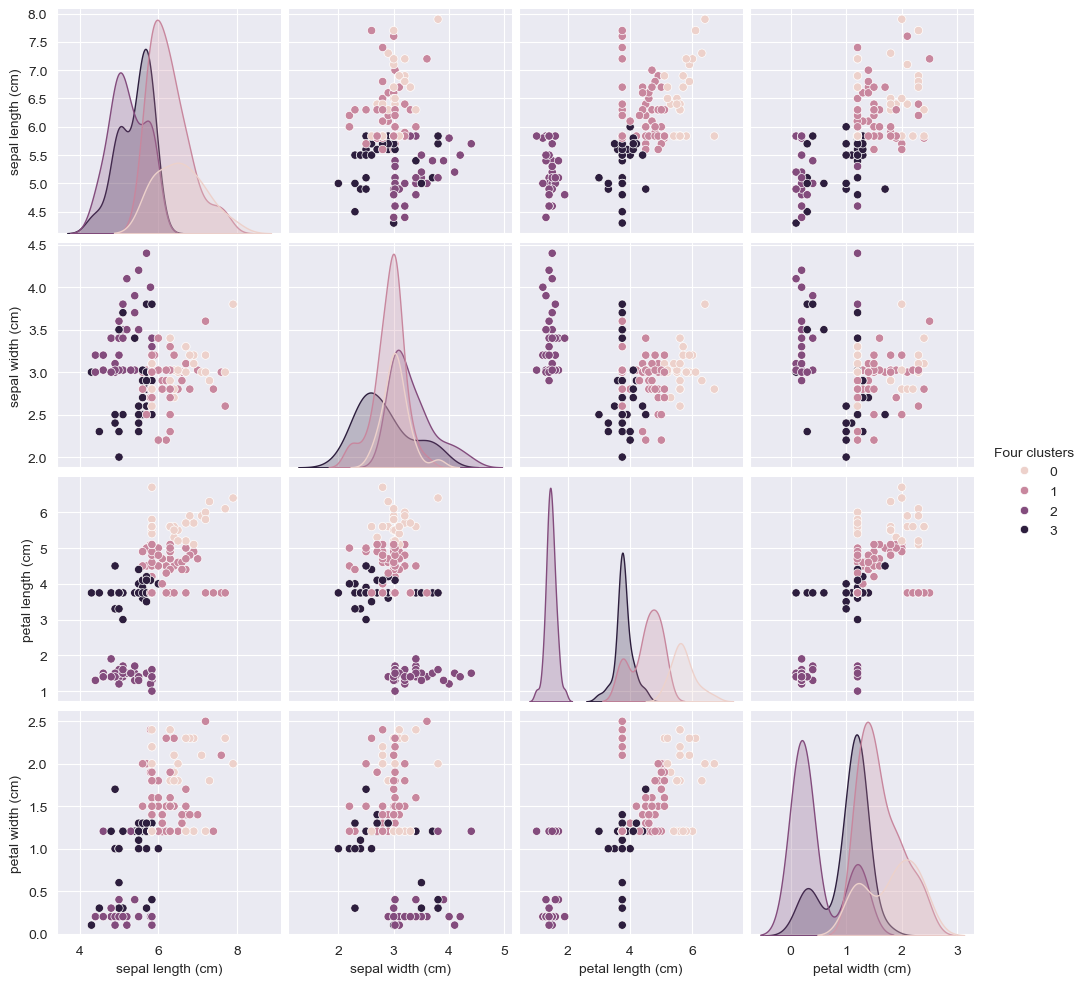

In [ ]:
#| column: page-right

k_means_zero = KMeans(n_clusters = 4, init = 'random', n_init = 10)
k_means_zero.fit(df_2)
df_2['Four clusters'] = pd.Series(k_means_zero.predict(df_2.iloc[:,0:4].values), index = df_2.index)
sns.pairplot(df_2, hue = 'Four clusters')

<Axes: xlabel='c1', ylabel='c2'>

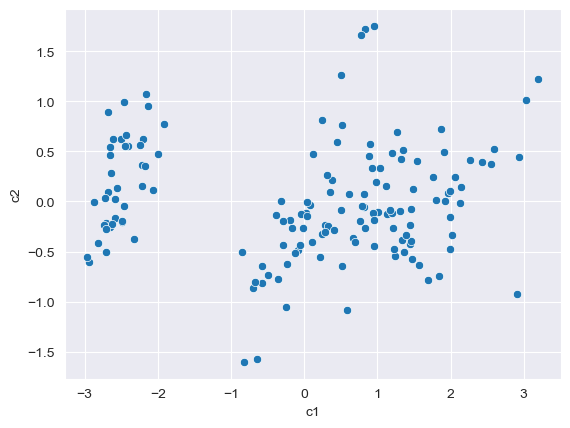

In [ ]:
# PCA analysis
n_components = 2

pca = PCA(n_components=n_components)
df_2_pca = pca.fit(df_2.iloc[:,0:4])

# Extract projected values
df_2_pca_vals = df_2_pca.transform(df_2.iloc[:,0:4])
df_2['c1'] = [item[0] for item in df_2_pca_vals]
df_2['c2'] = [item[1] for item in df_2_pca_vals]

sns.scatterplot(data = df_2, x = 'c1', y = 'c2')

In [ ]:
df_2_pca.explained_variance_

array([2.86183914, 0.32297801])

In [ ]:
df_2_pca.components_

array([[ 0.3096104 , -0.08037803,  0.89430094,  0.31290031],
       [ 0.8509381 ,  0.27794231, -0.36105217,  0.26133072]])

## Useful resources

The scikit learn UserGuide is very good. Both approaches here are often referred to as unsupervised learning methods and you can find the scikit learn section on these [here](https://scikit-learn.org/stable/unsupervised_learning.html).

If you have issues with the documentation then also look at the scikit-learn [examples](https://scikit-learn.org/stable/auto_examples/index.html).

Also, in no particular order:

* The [In-Depth sections of the Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/index.html). More for machine learning but interesting all the same.
* [Python for Data Analysis](https://www.amazon.co.uk/Python-Data-Analysis-Wes-Mckinney/dp/1491957662/ref=sr_1_3?dchild=1&keywords=Python+for+Data+Analysis%3A+Data+Wrangling&qid=1603809746&sr=8-3) (ebook is available via [Warwick library](https://encore.lib.warwick.ac.uk/iii/encore/search/C__Spython%20for%20data%20analysis__Orightresult__U;jsessionid=5A7D1DE9BAC479EE36B491F8FAC8F1FD?lang=eng))

In case you are bored:

* [Stack abuse](https://stackabuse.com/tag/python/) - Some fun blog entries to look at
* [Towards data science](https://towardsdatascience.com/) - a blog that contains a mix of intro, intermediate and advanced topics. Nice to skim through to try and undrestand something new.

Please do try out some of the techniques detailed in the lecture material The simple examples found in the scikit learn documentation are rather good. Generally, I find it much easier to try to understand a method using a simple dataset.